In [26]:
import pandas as pd

# 1. CSV 파일 로드
courses = pd.read_csv('../data/courses.csv')
assessments = pd.read_csv('../data/assessments.csv')
student_assess = pd.read_csv('../data/studentAssessment.csv')
student_info = pd.read_csv('../data/studentInfo.csv')
student_reg = pd.read_csv('../data/studentRegistration.csv')
student_vle = pd.read_csv('../data/studentVle.csv')
vle = pd.read_csv('../data/vle.csv')

# 2. 컬럼명 통일: courses
courses = courses.rename(columns={'module_presentation_length': 'length'})

# 3. student_info + courses 결합
df = student_info.merge(
    courses,
    on=['code_module', 'code_presentation'],
    how='left'
)

# 4. 등록/탈퇴 정보 추가
df = df.merge(
    student_reg[['code_module', 'code_presentation', 'id_student', 
                 'date_registration', 'date_unregistration']],
    on=['code_module', 'code_presentation', 'id_student'],
    how='left'
)

# 5. 평가 정보 집계: student_assess + assessments
assess_full = student_assess.merge(
    assessments,
    on='id_assessment',
    how='left'
)
assess_full['score'] = pd.to_numeric(assess_full['score'], errors='coerce')
assess_agg = assess_full.groupby(
    ['code_module', 'code_presentation', 'id_student']
).agg(
    avg_score=('score', 'mean'),
    num_assessments=('id_assessment', 'count')
).reset_index()
df = df.merge(
    assess_agg,
    on=['code_module', 'code_presentation', 'id_student'],
    how='left'
)

# 6. VLE 클릭 정보 집계: student_vle + vle
vle_full = student_vle.merge(
    vle,
    on=['id_site', 'code_module', 'code_presentation'],
    how='left'
)
vle_agg = vle_full.groupby(
    ['code_module', 'code_presentation', 'id_student']
).agg(
    total_clicks=('sum_click', 'sum'),
    unique_materials=('id_site', 'nunique')
).reset_index()
df = df.merge(
    vle_agg,
    on=['code_module', 'code_presentation', 'id_student'],
    how='left'
)

# 7. 결측치 처리
for col in ['date_registration', 'date_unregistration', 
            'avg_score', 'num_assessments', 
            'total_clicks', 'unique_materials']:
    df[col] = df[col].fillna(0)

# 8. 최종 파일 저장
df.to_csv('../data/merged_optimized.csv', index=False)


In [28]:
import pandas as pd

# 1. 기존 병합 파일 로드
df = pd.read_csv('../data/merged_optimized.csv')

# 2. studentAssessment.csv 로드 (id_student ↔ id_assessment 페어)
student_assess = pd.read_csv('../data/studentAssessment.csv')[['id_student', 'id_assessment']]

# 3. id_student 기준으로 병합 (한 학생이 여러 assessment를 가져도 중복 허용)
df_expanded = df.merge(student_assess, on='id_student', how='left')

# 4. 결과를 CSV로 저장
df_expanded.to_csv('../data/merged_with_all_assessments.csv', index=False)


In [29]:
df = pd.read_csv('../data/merged_with_all_assessments.csv')
df

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,length,date_registration,date_unregistration,avg_score,num_assessments,total_clicks,unique_materials,id_assessment
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,268,-159,?,82.000000,5.0,934.0,55.0,1752.0
1,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,268,-159,?,82.000000,5.0,934.0,55.0,1753.0
2,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,268,-159,?,82.000000,5.0,934.0,55.0,1754.0
3,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,268,-159,?,82.000000,5.0,934.0,55.0,1755.0
4,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,268,-159,?,82.000000,5.0,934.0,55.0,1756.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213161,GGG,2014J,2684003,F,Yorkshire Region,HE Qualification,50-60%,35-55,0,30,N,Distinction,269,-28,?,82.857143,7.0,616.0,32.0,37437.0
213162,GGG,2014J,2684003,F,Yorkshire Region,HE Qualification,50-60%,35-55,0,30,N,Distinction,269,-28,?,82.857143,7.0,616.0,32.0,37438.0
213163,GGG,2014J,2684003,F,Yorkshire Region,HE Qualification,50-60%,35-55,0,30,N,Distinction,269,-28,?,82.857143,7.0,616.0,32.0,37439.0
213164,GGG,2014J,2684003,F,Yorkshire Region,HE Qualification,50-60%,35-55,0,30,N,Distinction,269,-28,?,82.857143,7.0,616.0,32.0,37440.0


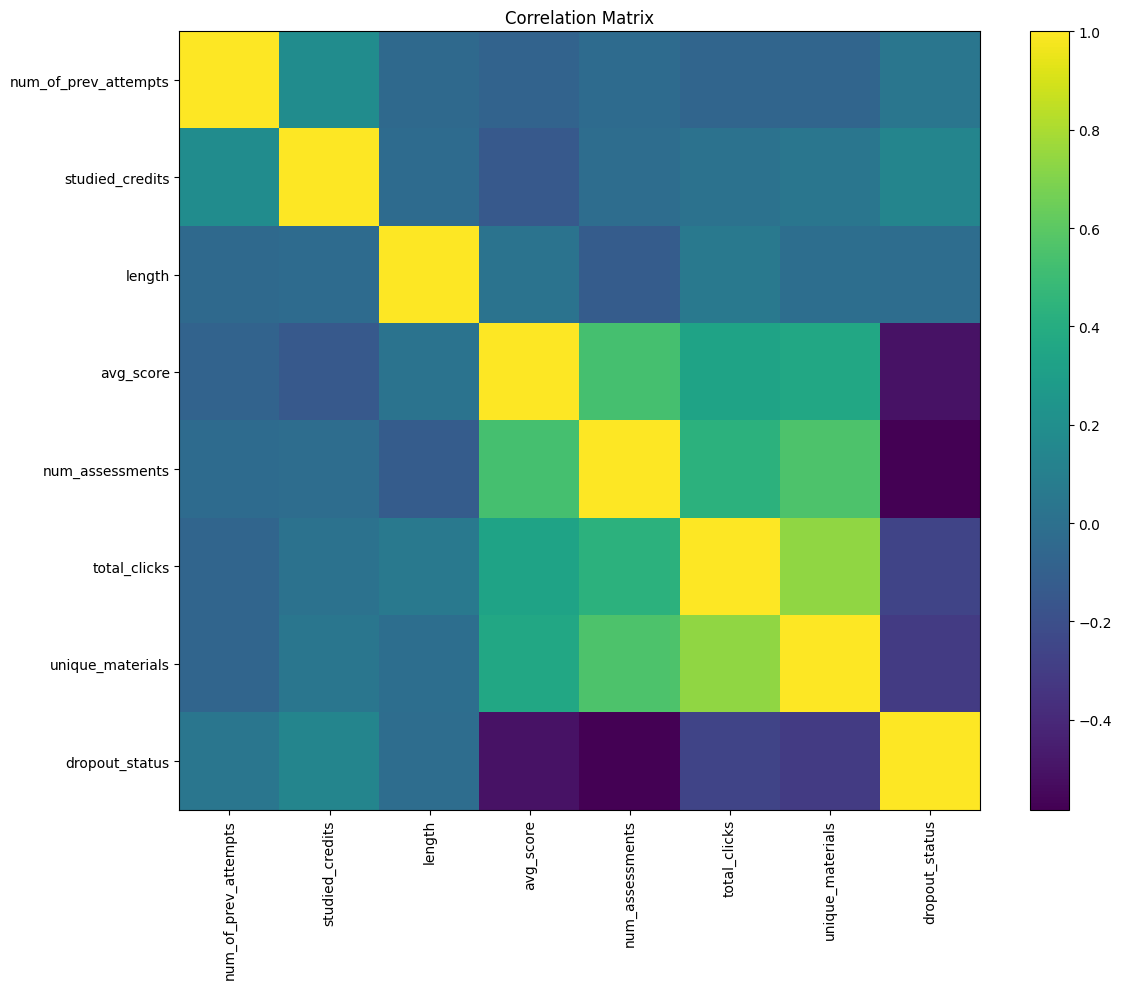

Top 10 Correlated Pairs:
            var1             var2      corr
    total_clicks unique_materials  0.736704
 num_assessments   dropout_status -0.582595
 num_assessments unique_materials  0.557533
       avg_score  num_assessments  0.535953
       avg_score   dropout_status -0.505660
 num_assessments     total_clicks  0.434035
       avg_score unique_materials  0.365201
       avg_score     total_clicks  0.334024
unique_materials   dropout_status -0.308540
    total_clicks   dropout_status -0.256562

K=5 -> Train Accuracy: 0.9838, Test Accuracy: 0.9693

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     36509
           1       0.88      0.91      0.89      6125

    accuracy                           0.97     42634
   macro avg       0.93      0.94      0.94     42634
weighted avg       0.97      0.97      0.97     42634



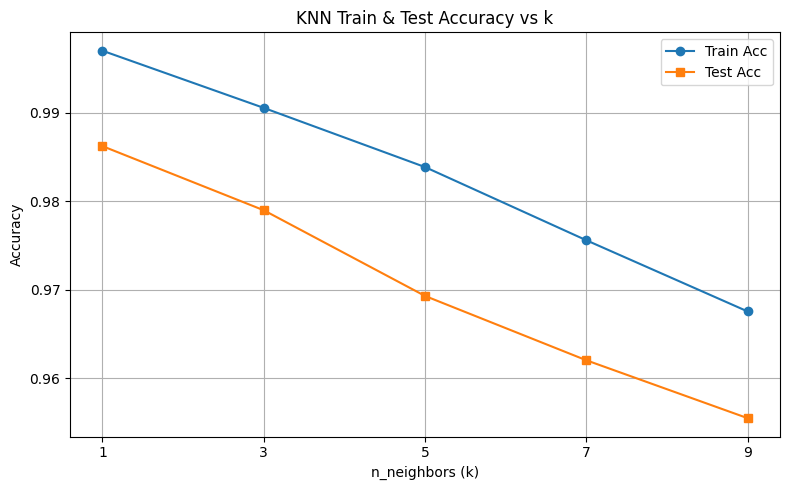

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# 1. 데이터 로드
df = pd.read_csv('../data/lets_go.csv')

# 2. 이탈 여부 이진 변수 생성
df['dropout_status'] = (df['final_result'] == 'Withdrawn').astype(int)

# 3. 수치형 피처만 선택 (ID나 텍스트 컬럼 제외)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['dropout_status', 'id_student', 'id_assessment', 'id_site']]

# 4. 상관관계 분석
corr = df[numeric_cols + ['dropout_status']].corr()

# 4-1. 히트맵 그리기
plt.figure(figsize=(12, 10))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# 4-2. 상위 상관 페어 출력
corr_pairs = corr.unstack().reset_index()
corr_pairs.columns = ['var1', 'var2', 'corr']
corr_pairs = corr_pairs[corr_pairs['var1'] != corr_pairs['var2']]
corr_pairs['abs_corr'] = corr_pairs['corr'].abs()
corr_pairs['pair'] = corr_pairs.apply(lambda r: tuple(sorted((r['var1'], r['var2']))), axis=1)
corr_pairs = corr_pairs.drop_duplicates(subset='pair')
top_pairs = corr_pairs.sort_values('abs_corr', ascending=False).head(10)
print("Top 10 Correlated Pairs:")
print(top_pairs[['var1', 'var2', 'corr']].to_string(index=False))

# 5. KNN 분석
X = df[numeric_cols]
y = df['dropout_status']

# 5-1. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5-2. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 5-3. 기본 k=5 모델 학습/평가
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

train_acc = knn.score(X_train_scaled, y_train)
test_acc  = knn.score(X_test_scaled, y_test)

print(f"\nK=5 -> Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, knn.predict(X_test_scaled)))

# 6. k 변화에 따른 학습/테스트 정확도 비교
k_values = [1, 3, 5, 7, 9]
train_scores, test_scores = [], []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scaled, y_train)
    train_scores.append(model.score(X_train_scaled, y_train))
    test_scores.append(model.score(X_test_scaled, y_test))

plt.figure(figsize=(8, 5))
plt.plot(k_values, train_scores, marker='o', label='Train Acc')
plt.plot(k_values, test_scores, marker='s', label='Test Acc')
plt.xlabel('n_neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Train & Test Accuracy vs k')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Top KNN Permutation Importances:
             feature  importance
     num_assessments    0.196503
           avg_score    0.084050
    unique_materials    0.077452
        total_clicks    0.064223
              length    0.061442
     studied_credits    0.055390
num_of_prev_attempts    0.023634


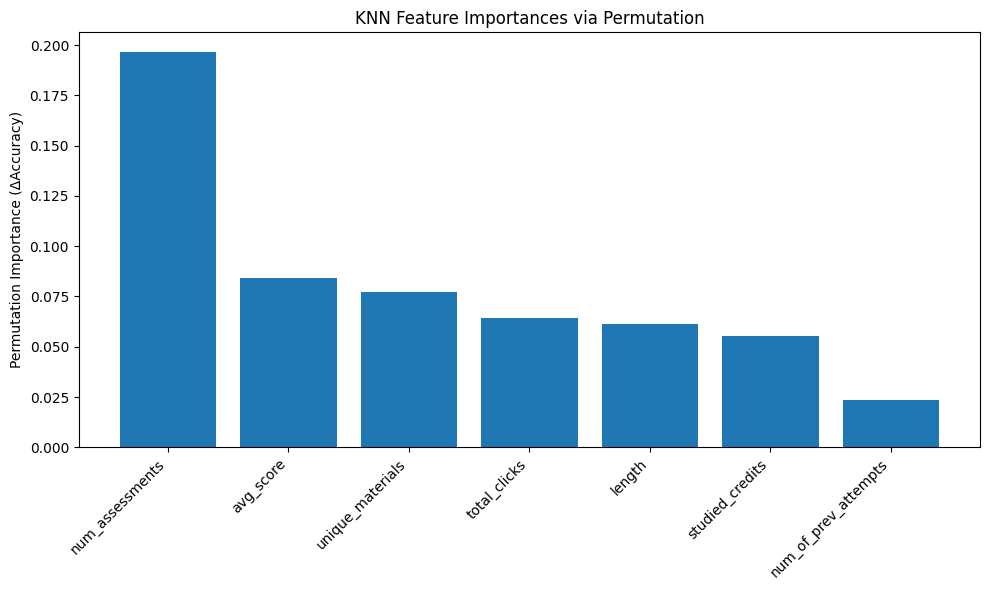

In [31]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# (1) 이미 학습된 KNN 모델, 스케일러, 그리고 테스트 데이터를 준비했다고 가정합니다:
#    knn, scaler, X_test, y_test

# 2) 테스트 데이터 스케일링
X_test_scaled = scaler.transform(X_test)

# 3) 순열 중요도 계산
perm_res = permutation_importance(
    knn, 
    X_test_scaled, 
    y_test, 
    n_repeats=10, 
    random_state=42,
    scoring='accuracy'
)

# 4) 결과 정리
feat_names = X_test.columns
importances = perm_res.importances_mean
imp_df = pd.DataFrame({
    'feature': feat_names, 
    'importance': importances
}).sort_values('importance', ascending=False).reset_index(drop=True)

# 5) 상위 10개 출력
print("Top KNN Permutation Importances:")
print(imp_df.to_string(index=False))

# 6) 시각화
plt.figure(figsize=(10, 6))
plt.bar(imp_df['feature'], imp_df['importance'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Permutation Importance (ΔAccuracy)')
plt.title('KNN Feature Importances via Permutation')
plt.tight_layout()
plt.show()


In [38]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 1. CSV 파일 로드 (필요에 따라 파일명을 수정하세요)
df = pd.read_csv('../data/lets_go.csv')

# 2. object dtype(문자열) 컬럼 리스트 추출
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# 3. 각 컬럼별 LabelEncoder 적용
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    # NaN이 있을 경우 문자열로 변환하여 처리
    df[col] = le.fit_transform(df[col].astype(str))
    # 매핑 사전 저장 (원본값 → 인코딩 값)
    encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# 4. 인코딩 결과 저장
df.to_csv('../data/lets_go_label_encoded.csv', index=False)

# (선택) 인코더 매핑 확인
for col, mapping in encoders.items():
    print(f"{col} mapping: {mapping}")


code_module mapping: {'AAA': np.int64(0), 'BBB': np.int64(1), 'CCC': np.int64(2), 'DDD': np.int64(3), 'EEE': np.int64(4), 'FFF': np.int64(5), 'GGG': np.int64(6)}
code_presentation mapping: {'2013B': np.int64(0), '2013J': np.int64(1), '2014B': np.int64(2), '2014J': np.int64(3)}
gender mapping: {'F': np.int64(0), 'M': np.int64(1)}
region mapping: {'East Anglian Region': np.int64(0), 'East Midlands Region': np.int64(1), 'Ireland': np.int64(2), 'London Region': np.int64(3), 'North Region': np.int64(4), 'North Western Region': np.int64(5), 'Scotland': np.int64(6), 'South East Region': np.int64(7), 'South Region': np.int64(8), 'South West Region': np.int64(9), 'Wales': np.int64(10), 'West Midlands Region': np.int64(11), 'Yorkshire Region': np.int64(12)}
highest_education mapping: {'A Level or Equivalent': np.int64(0), 'HE Qualification': np.int64(1), 'Lower Than A Level': np.int64(2), 'No Formal quals': np.int64(3), 'Post Graduate Qualification': np.int64(4)}
imd_band mapping: {'0-10%': np.i

In [39]:
df = pd.read_csv('../data/lets_go_label_encoded.csv')
df

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,length,date_registration,date_unregistration,avg_score,num_assessments,total_clicks,unique_materials,id_assessment
0,0,1,11391,1,0,1,9,2,0,240,0,2,268,66,416,82.000000,5.0,934.0,55.0,1752.0
1,0,1,11391,1,0,1,9,2,0,240,0,2,268,66,416,82.000000,5.0,934.0,55.0,1753.0
2,0,1,11391,1,0,1,9,2,0,240,0,2,268,66,416,82.000000,5.0,934.0,55.0,1754.0
3,0,1,11391,1,0,1,9,2,0,240,0,2,268,66,416,82.000000,5.0,934.0,55.0,1755.0
4,0,1,11391,1,0,1,9,2,0,240,0,2,268,66,416,82.000000,5.0,934.0,55.0,1756.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213161,6,3,2684003,0,12,1,5,1,0,30,0,0,269,190,416,82.857143,7.0,616.0,32.0,37437.0
213162,6,3,2684003,0,12,1,5,1,0,30,0,0,269,190,416,82.857143,7.0,616.0,32.0,37438.0
213163,6,3,2684003,0,12,1,5,1,0,30,0,0,269,190,416,82.857143,7.0,616.0,32.0,37439.0
213164,6,3,2684003,0,12,1,5,1,0,30,0,0,269,190,416,82.857143,7.0,616.0,32.0,37440.0


k= 1 -> Train Acc: 1.0000, Test Acc: 0.9857
k= 3 -> Train Acc: 0.9897, Test Acc: 0.9766
k= 5 -> Train Acc: 0.9799, Test Acc: 0.9659
k= 7 -> Train Acc: 0.9686, Test Acc: 0.9537
k= 9 -> Train Acc: 0.9572, Test Acc: 0.9437
k=11 -> Train Acc: 0.9481, Test Acc: 0.9366
k=13 -> Train Acc: 0.9403, Test Acc: 0.9287
k=15 -> Train Acc: 0.9337, Test Acc: 0.9230


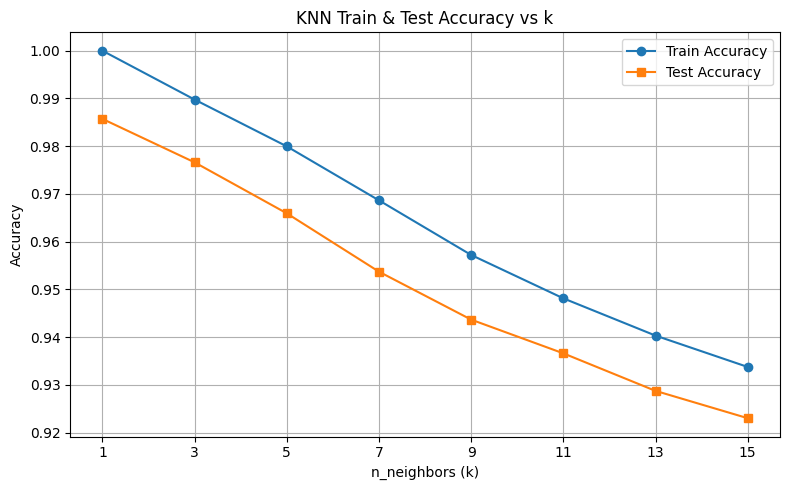

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 1. 데이터 로드
df = pd.read_csv('../data/lets_go_label_encoded.csv')

# 2. dropout_status 컬럼 생성: Withdrawn인 3 이면 1, 나머지 0
df['dropout_status'] = (df['final_result'] == 3).astype(int)

# 3. 기존 final_result 컬럼 제거
df = df.drop(columns=['final_result'])

# 2. 특성과 타깃 분리
X = df.drop(columns=['dropout_status', 'id_student', 'id_assessment','code_module', 'code_presentation','date_unregistration','num_assessments','total_clicks','unique_materials'])
y = df['dropout_status']

# 3. 학습/테스트셋 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. 특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 5. 다양한 k 값에 대한 정확도 측정
k_values = list(range(1, 16, 2))  # 1,3,5,...,15
train_accuracies = []
test_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_acc = knn.score(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, y_pred)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"k={k:2d} -> Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

# 6. k에 따른 정확도 그래프
plt.figure(figsize=(8, 5))
plt.plot(k_values, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(k_values, test_accuracies, marker='s', label='Test Accuracy')
plt.xticks(k_values)
plt.xlabel('n_neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Train & Test Accuracy vs k')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


=== Classification Report (k=5) ===

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     36509
           1       0.92      0.83      0.88      6125

    accuracy                           0.97     42634
   macro avg       0.95      0.91      0.93     42634
weighted avg       0.97      0.97      0.97     42634


=== Correlation with dropout_status ===

studied_credits         0.137883
disability              0.061645
code_presentation       0.045559
num_of_prev_attempts    0.041739
highest_education       0.040324
gender                  0.029998
id_assessment           0.008985
id_student              0.007606
region                  0.003748
length                 -0.017166
age_band               -0.017466
date_registration      -0.035228
imd_band               -0.050287
code_module            -0.086866
total_clicks           -0.256562
unique_materials       -0.308540
avg_score              -0.505660
num_assessments        -0.582595


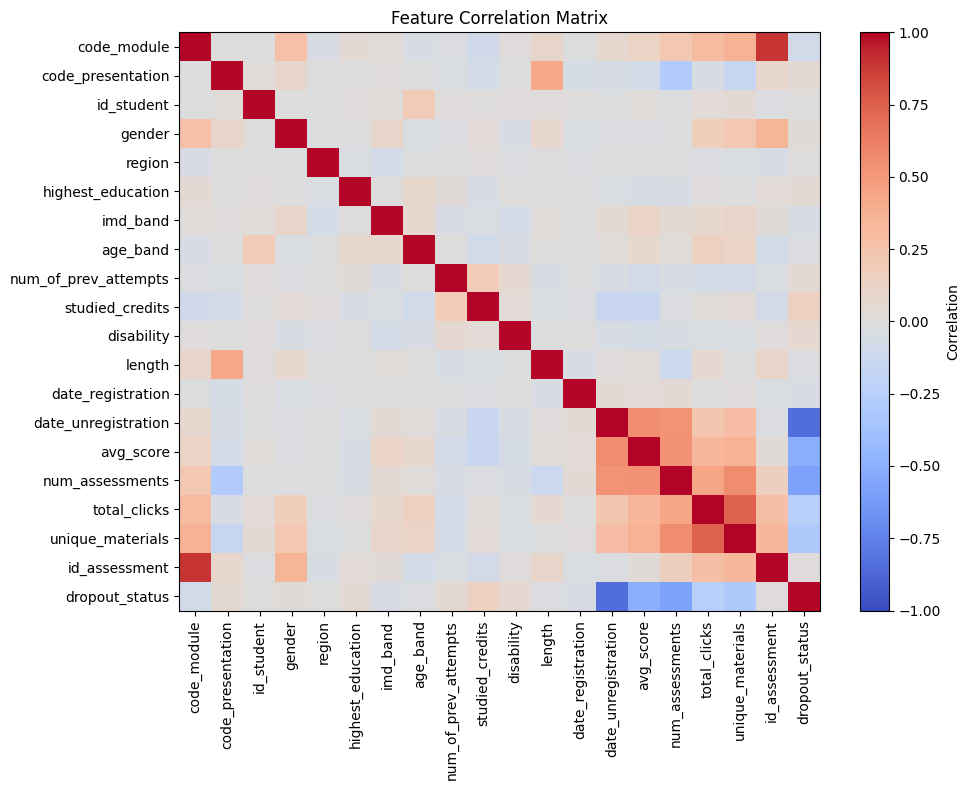

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# 1. 데이터 로드
df = pd.read_csv('../data/lets_go_label_encoded.csv')

# 2. dropout_status 생성 (Withdrawn 라벨이 3이라 가정)
df['dropout_status'] = (df['final_result'] == 3).astype(int)
df = df.drop(columns=['final_result'])

# 3. 특성과 타깃 분리
X = df.drop(columns=[
    'dropout_status',
    'id_student',
    'id_assessment',
    'code_module',
    'code_presentation',
    'date_unregistration',
    'num_assessments',
    'total_clicks',
    'unique_materials'
])
y = df['dropout_status']

# 4. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 6. 최적 k 선택 예시 (여기서는 k=5 사용)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# 7. 테스트 성능 리포트
y_pred = knn.predict(X_test_scaled)
print("=== Classification Report (k=5) ===\n")
print(classification_report(y_test, y_pred))

# 8. 변수 간 상관관계 분석
#    (숫자형 컬럼만 모아서 dropout_status와의 상관계수 계산)
numeric = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric.remove('dropout_status')

corr_with_target = df[numeric + ['dropout_status']] \
    .corr()['dropout_status'] \
    .drop('dropout_status') \
    .sort_values(ascending=False)

print("\n=== Correlation with dropout_status ===\n")
print(corr_with_target.to_string())

# 9. 전체 상관행렬 히트맵 (원한다면)
plt.figure(figsize=(10, 8))
corr_matrix = df[numeric + ['dropout_status']].corr()
plt.imshow(corr_matrix, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.index)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd

# 1. 원본 CSV 읽기
df = pd.read_csv('../data/lets_go.csv')

# 2. 고유한 code_presentation 값 확인
presentations = df['code_presentation'].unique()
print("발견된 code_presentation:", presentations)

# 3. 각 값별로 CSV 저장
for pres in presentations:
    df_filtered = df[df['code_presentation'] == pres]
    output_path = f'lets_go_{pres}.csv'
    df_filtered.to_csv(output_path, index=False)
    print(f"저장 완료: {output_path} ({len(df_filtered)} 행)")


발견된 code_presentation: ['2013J' '2014J' '2013B' '2014B']
저장 완료: lets_go_2013J.csv (57657 행)
저장 완료: lets_go_2014J.csv (66927 행)
저장 완료: lets_go_2013B.csv (37130 행)
저장 완료: lets_go_2014B.csv (51452 행)


In [12]:
import pandas as pd

# 1. 원본 CSV 읽기
df_2013B = pd.read_csv('../data/lets_go_2013B.csv')
df_2013J = pd.read_csv('../data/lets_go_2013J.csv')
df_2014B = pd.read_csv('../data/lets_go_2014B.csv')
df_2014J = pd.read_csv('../data/lets_go_2014J.csv')

C:\Users\김준협\AppData\Local\Temp\ipykernel_10272\1566826885.py:7: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2014J = pd.read_csv('../data/lets_go_2014J.csv')


In [46]:
import pandas as pd

# ===== 설정 =====
INPUT_PATH = '../data/lets_go_2013B.csv'
OUTPUT_PREFIX = 'lets_go'   # 저장 파일 접두사
# 우선순위 후보: (컬럼명, 내림차순여부)  True=내림차순(큰 값 우선), False=오름차순(작은 값 우선)
PRIORITY_CANDIDATES = [
    ('score', True),         # 점수 높은 것 우선
    ('sum_click', True),     # 클릭 많은 것 우선
    ('retry_count', False),  # 재시도 횟수 적은 것 우선
]

# ===== 로드 =====
df = pd.read_csv(INPUT_PATH)
print(f'원본 행수: {len(df):,}')
print('사용 가능한 컬럼:', list(df.columns))

# ===== 실제 존재하는 우선순위만 사용 =====
priority_order = [(c, desc) for c, desc in PRIORITY_CANDIDATES if c in df.columns]
if len(priority_order) == 0:
    print("※ 우선순위 후보 컬럼이 데이터에 없습니다. (score/sum_click/retry_count 미존재) → 첫 행 유지 규칙으로 진행합니다.")

# ===== 정렬 준비(필요한 컬럼만 변환/결측치 처리) =====
if priority_order:
    for col, desc in priority_order:
        # 숫자형 변환
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # 결측치: 내림차순(큰 값 우선)일 때 NaN -> -inf, 오름차순(작은 값 우선)일 때 NaN -> +inf
        df[col] = df[col].fillna(float('-inf') if desc else float('inf'))

    sort_cols = [c for c, _ in priority_order]
    ascending = [not d for _, d in priority_order]  # desc=True -> ascending=False
    df_sorted = df.sort_values(by=sort_cols, ascending=ascending, kind='mergesort')
else:
    # 우선순위 컬럼이 하나도 없으면 원본 순서를 유지(안정 정렬)
    df_sorted = df.copy()

# ===== 학생×발표차수 단위로 1행만 남김 =====
before = len(df_sorted)
dedup = df_sorted.drop_duplicates(subset=['id_student', 'code_presentation'], keep='first')
after = len(dedup)
print(f'중복 제거: {before:,} -> {after:,} (-{before-after:,})  기준: id_student + code_presentation'
      + (f', 우선순위={priority_order}' if priority_order else ', 우선순위=없음(첫 행 유지)'))

df_2013B_clean = dedup.drop(['id_assessment', 'code_module', 'code_presentation','length','id_assessment'], axis=1)
df_2013B_clean

원본 행수: 37,130
사용 가능한 컬럼: ['code_module', 'code_presentation', 'id_student', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'final_result', 'length', 'date_registration', 'date_unregistration', 'avg_score', 'num_assessments', 'total_clicks', 'unique_materials', 'id_assessment']
※ 우선순위 후보 컬럼이 데이터에 없습니다. (score/sum_click/retry_count 미존재) → 첫 행 유지 규칙으로 진행합니다.
중복 제거: 37,130 -> 4,679 (-32,451)  기준: id_student + code_presentation, 우선순위=없음(첫 행 유지)


,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,avg_score,num_assessments,total_clicks,unique_materials
0,23629,F,East Anglian Region,Lower Than A Level,20-30%,0-35,2,60,N,Fail,-47,?,82.500000,4.0,161.0,11.0
4,25107,F,East Anglian Region,Lower Than A Level,20-30%,0-35,0,120,N,Pass,-73,?,77.363636,11.0,2562.0,42.0
15,27891,M,Scotland,Lower Than A Level,0-10%,0-35,2,120,Y,Withdrawn,-58,153,69.166667,6.0,301.0,25.0
27,29144,M,South Region,Lower Than A Level,60-70%,0-35,0,120,N,Fail,-24,?,73.222222,9.0,1914.0,138.0
36,31663,M,North Region,A Level or Equivalent,30-40%,35-55,0,60,N,Pass,-60,?,79.272727,11.0,5906.0,114.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37098,2686866,M,London Region,A Level or Equivalent,50-60%,0-35,0,60,N,Fail,-23,?,64.000000,2.0,402.0,47.0
37100,2686875,F,East Midlands Region,A Level or Equivalent,20-30%,35-55,0,60,N,Pass,-22,?,79.916667,12.0,3419.0,119.0
37112,2687045,M,South West Region,Lower Than A Level,50-60%,0-35,0,60,N,Withdrawn,-161,73,60.333333,3.0,2871.0,96.0
37118,2688202,F,East Midlands Region,Lower Than A Level,10-20,0-35,1,90,N,Withdrawn,-146,200,0.000000,0.0,74.0,18.0


In [25]:
import pandas as pd

# ===== 설정 =====
INPUT_PATH = '../data/lets_go_2013J.csv'
OUTPUT_PREFIX = 'lets_go'   # 저장 파일 접두사
# 우선순위 후보: (컬럼명, 내림차순여부)  True=내림차순(큰 값 우선), False=오름차순(작은 값 우선)
PRIORITY_CANDIDATES = [
    ('score', True),         # 점수 높은 것 우선
    ('sum_click', True),     # 클릭 많은 것 우선
    ('retry_count', False),  # 재시도 횟수 적은 것 우선
]

# ===== 로드 =====
df = pd.read_csv(INPUT_PATH)
print(f'원본 행수: {len(df):,}')
print('사용 가능한 컬럼:', list(df.columns))

# ===== 실제 존재하는 우선순위만 사용 =====
priority_order = [(c, desc) for c, desc in PRIORITY_CANDIDATES if c in df.columns]
if len(priority_order) == 0:
    print("※ 우선순위 후보 컬럼이 데이터에 없습니다. (score/sum_click/retry_count 미존재) → 첫 행 유지 규칙으로 진행합니다.")

# ===== 정렬 준비(필요한 컬럼만 변환/결측치 처리) =====
if priority_order:
    for col, desc in priority_order:
        # 숫자형 변환
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # 결측치: 내림차순(큰 값 우선)일 때 NaN -> -inf, 오름차순(작은 값 우선)일 때 NaN -> +inf
        df[col] = df[col].fillna(float('-inf') if desc else float('inf'))

    sort_cols = [c for c, _ in priority_order]
    ascending = [not d for _, d in priority_order]  # desc=True -> ascending=False
    df_sorted = df.sort_values(by=sort_cols, ascending=ascending, kind='mergesort')
else:
    # 우선순위 컬럼이 하나도 없으면 원본 순서를 유지(안정 정렬)
    df_sorted = df.copy()

# ===== 학생×발표차수 단위로 1행만 남김 =====
before = len(df_sorted)
dedup = df_sorted.drop_duplicates(subset=['id_student', 'code_presentation'], keep='first')
after = len(dedup)
print(f'중복 제거: {before:,} -> {after:,} (-{before-after:,})  기준: id_student + code_presentation'
      + (f', 우선순위={priority_order}' if priority_order else ', 우선순위=없음(첫 행 유지)'))

df_2013J_clean = dedup.drop(['id_assessment', 'code_module', 'code_presentation','length','id_assessment'], axis=1)
df_2013J_clean

원본 행수: 57,657
사용 가능한 컬럼: ['code_module', 'code_presentation', 'id_student', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'final_result', 'length', 'date_registration', 'date_unregistration', 'avg_score', 'num_assessments', 'total_clicks', 'unique_materials', 'id_assessment']
※ 우선순위 후보 컬럼이 데이터에 없습니다. (score/sum_click/retry_count 미존재) → 첫 행 유지 규칙으로 진행합니다.
중복 제거: 57,657 -> 8,830 (-48,827)  기준: id_student + code_presentation, 우선순위=없음(첫 행 유지)


,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,avg_score,num_assessments,total_clicks,unique_materials
0,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159,?,82.000000,5.0,934.0,55.0
5,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53,?,66.400000,5.0,1435.0,84.0
10,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92,12,0.000000,0.0,281.0,22.0
11,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52,?,76.000000,5.0,2158.0,82.0
16,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176,?,54.400000,5.0,1034.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57636,2670570,M,Yorkshire Region,A Level or Equivalent,40-50%,0-35,0,30,N,Pass,-38,?,91.000000,9.0,1389.0,60.0
57645,2673510,F,East Midlands Region,Lower Than A Level,20-30%,35-55,0,30,N,Withdrawn,3,102,80.000000,1.0,230.0,16.0
57646,2674822,F,North Western Region,A Level or Equivalent,0-10%,0-35,0,30,N,Fail,-22,?,0.000000,0.0,96.0,15.0
57647,2679386,F,South Region,A Level or Equivalent,10-20,35-55,0,30,N,Distinction,-100,?,90.333333,9.0,855.0,45.0


In [27]:
import pandas as pd

# ===== 설정 =====
INPUT_PATH = '../data/lets_go_2014B.csv'
OUTPUT_PREFIX = 'lets_go'   # 저장 파일 접두사
# 우선순위 후보: (컬럼명, 내림차순여부)  True=내림차순(큰 값 우선), False=오름차순(작은 값 우선)
PRIORITY_CANDIDATES = [
    ('score', True),         # 점수 높은 것 우선
    ('sum_click', True),     # 클릭 많은 것 우선
    ('retry_count', False),  # 재시도 횟수 적은 것 우선
]

# ===== 로드 =====
df = pd.read_csv(INPUT_PATH)
print(f'원본 행수: {len(df):,}')
print('사용 가능한 컬럼:', list(df.columns))

# ===== 실제 존재하는 우선순위만 사용 =====
priority_order = [(c, desc) for c, desc in PRIORITY_CANDIDATES if c in df.columns]
if len(priority_order) == 0:
    print("※ 우선순위 후보 컬럼이 데이터에 없습니다. (score/sum_click/retry_count 미존재) → 첫 행 유지 규칙으로 진행합니다.")

# ===== 정렬 준비(필요한 컬럼만 변환/결측치 처리) =====
if priority_order:
    for col, desc in priority_order:
        # 숫자형 변환
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # 결측치: 내림차순(큰 값 우선)일 때 NaN -> -inf, 오름차순(작은 값 우선)일 때 NaN -> +inf
        df[col] = df[col].fillna(float('-inf') if desc else float('inf'))

    sort_cols = [c for c, _ in priority_order]
    ascending = [not d for _, d in priority_order]  # desc=True -> ascending=False
    df_sorted = df.sort_values(by=sort_cols, ascending=ascending, kind='mergesort')
else:
    # 우선순위 컬럼이 하나도 없으면 원본 순서를 유지(안정 정렬)
    df_sorted = df.copy()

# ===== 학생×발표차수 단위로 1행만 남김 =====
before = len(df_sorted)
dedup = df_sorted.drop_duplicates(subset=['id_student', 'code_presentation'], keep='first')
after = len(dedup)
print(f'중복 제거: {before:,} -> {after:,} (-{before-after:,})  기준: id_student + code_presentation'
      + (f', 우선순위={priority_order}' if priority_order else ', 우선순위=없음(첫 행 유지)'))

df_2014B_clean = dedup.drop(['id_assessment', 'code_module', 'code_presentation','length','id_assessment'], axis=1)
df_2014B_clean

원본 행수: 51,452
사용 가능한 컬럼: ['code_module', 'code_presentation', 'id_student', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'final_result', 'length', 'date_registration', 'date_unregistration', 'avg_score', 'num_assessments', 'total_clicks', 'unique_materials', 'id_assessment']
※ 우선순위 후보 컬럼이 데이터에 없습니다. (score/sum_click/retry_count 미존재) → 첫 행 유지 규칙으로 진행합니다.
중복 제거: 51,452 -> 7,333 (-44,119)  기준: id_student + code_presentation, 우선순위=없음(첫 행 유지)


,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,avg_score,num_assessments,total_clicks,unique_materials
0,25629,F,Scotland,Lower Than A Level,20-30%,0-35,1,120,N,Withdrawn,-156,108,0.000000,0.0,16.0,3.0
1,25997,F,London Region,A Level or Equivalent,20-30%,0-35,2,60,N,Withdrawn,-139,83,86.500000,2.0,13.0,2.0
3,27891,M,Scotland,Lower Than A Level,0-10%,0-35,4,120,Y,Fail,-191,?,69.166667,6.0,47.0,7.0
15,38941,F,East Midlands Region,A Level or Equivalent,10-20,0-35,0,60,N,Fail,-24,?,77.000000,1.0,0.0,0.0
16,50069,F,Scotland,A Level or Equivalent,30-40%,0-35,0,90,N,Fail,-134,?,84.833333,6.0,531.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51409,2672138,F,North Western Region,Lower Than A Level,10-20,35-55,0,30,Y,Distinction,-71,?,91.428571,7.0,768.0,62.0
51416,2677135,M,Yorkshire Region,Lower Than A Level,70-80%,0-35,0,30,N,Pass,-113,?,89.444444,9.0,419.0,42.0
51425,2682002,F,Yorkshire Region,Lower Than A Level,80-90%,35-55,0,30,N,Distinction,-92,?,90.000000,9.0,813.0,38.0
51434,2689480,F,North Region,A Level or Equivalent,40-50%,35-55,0,30,N,Pass,-11,?,82.444444,9.0,826.0,61.0


In [28]:
import pandas as pd

# ===== 설정 =====
INPUT_PATH = '../data/lets_go_2014J.csv'
OUTPUT_PREFIX = 'lets_go'   # 저장 파일 접두사
# 우선순위 후보: (컬럼명, 내림차순여부)  True=내림차순(큰 값 우선), False=오름차순(작은 값 우선)
PRIORITY_CANDIDATES = [
    ('score', True),         # 점수 높은 것 우선
    ('sum_click', True),     # 클릭 많은 것 우선
    ('retry_count', False),  # 재시도 횟수 적은 것 우선
]

# ===== 로드 =====
df = pd.read_csv(INPUT_PATH)
print(f'원본 행수: {len(df):,}')
print('사용 가능한 컬럼:', list(df.columns))

# ===== 실제 존재하는 우선순위만 사용 =====
priority_order = [(c, desc) for c, desc in PRIORITY_CANDIDATES if c in df.columns]
if len(priority_order) == 0:
    print("※ 우선순위 후보 컬럼이 데이터에 없습니다. (score/sum_click/retry_count 미존재) → 첫 행 유지 규칙으로 진행합니다.")

# ===== 정렬 준비(필요한 컬럼만 변환/결측치 처리) =====
if priority_order:
    for col, desc in priority_order:
        # 숫자형 변환
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # 결측치: 내림차순(큰 값 우선)일 때 NaN -> -inf, 오름차순(작은 값 우선)일 때 NaN -> +inf
        df[col] = df[col].fillna(float('-inf') if desc else float('inf'))

    sort_cols = [c for c, _ in priority_order]
    ascending = [not d for _, d in priority_order]  # desc=True -> ascending=False
    df_sorted = df.sort_values(by=sort_cols, ascending=ascending, kind='mergesort')
else:
    # 우선순위 컬럼이 하나도 없으면 원본 순서를 유지(안정 정렬)
    df_sorted = df.copy()

# ===== 학생×발표차수 단위로 1행만 남김 =====
before = len(df_sorted)
dedup = df_sorted.drop_duplicates(subset=['id_student', 'code_presentation'], keep='first')
after = len(dedup)
print(f'중복 제거: {before:,} -> {after:,} (-{before-after:,})  기준: id_student + code_presentation'
      + (f', 우선순위={priority_order}' if priority_order else ', 우선순위=없음(첫 행 유지)'))

df_2014J_clean = dedup.drop(['id_assessment', 'code_module', 'code_presentation','length','id_assessment'], axis=1)
df_2014J_clean

원본 행수: 66,927
사용 가능한 컬럼: ['code_module', 'code_presentation', 'id_student', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'final_result', 'length', 'date_registration', 'date_unregistration', 'avg_score', 'num_assessments', 'total_clicks', 'unique_materials', 'id_assessment']
※ 우선순위 후보 컬럼이 데이터에 없습니다. (score/sum_click/retry_count 미존재) → 첫 행 유지 규칙으로 진행합니다.
중복 제거: 66,927 -> 10,670 (-56,257)  기준: id_student + code_presentation, 우선순위=없음(첫 행 유지)


C:\Users\김준협\AppData\Local\Temp\ipykernel_10272\150223590.py:14: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_PATH)


,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,avg_score,num_assessments,total_clicks,unique_materials
0,6516,M,Scotland,HE Qualification,80-90%,55<=,0,60,N,Pass,-52,?,61.800000,5.0,2791.0,84.0
5,24734,F,South Region,Lower Than A Level,60-70%,0-35,0,60,N,Pass,-18,?,46.800000,5.0,499.0,50.0
10,26192,F,East Anglian Region,A Level or Equivalent,60-70%,35-55,0,60,N,Distinction,-38,?,86.200000,5.0,2223.0,69.0
15,28061,M,Yorkshire Region,Lower Than A Level,40-50%,35-55,0,60,N,Pass,-130,?,77.600000,5.0,1590.0,82.0
20,31600,F,South West Region,A Level or Equivalent,40-50%,0-35,0,60,N,Pass,-52,?,54.800000,5.0,429.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66899,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,-4,?,0.000000,0.0,41.0,8.0
66900,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,-23,?,88.111111,9.0,893.0,50.0
66909,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,-129,?,76.666667,9.0,312.0,28.0
66918,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,-49,101,91.500000,2.0,275.0,17.0


# df_2014J_clean XGBoost로 결과 확인

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# 1. 데이터 로드
df = df_2014J_clean

# 2. 타겟 생성
df["target"] = df["final_result"].apply(lambda x: 1 if x == "Withdrawn" else 0)

# 3. 범주형 라벨 인코딩
label_encoders = {}
for col in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# 4. X, y 분리
X = df.drop(columns=["target", "id_student", "final_result"], errors="ignore")
y = df["target"]

# 5. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. 스케일링
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# 7. SMOTE 적용
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sc, y_train)

# 8. XGBoost 학습
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)
xgb.fit(X_train_res, y_train_res)

# 9. 예측
y_train_pred = xgb.predict(X_train_res)
y_test_pred = xgb.predict(X_test_sc)

# 10. 성능 출력
print("Train Accuracy:", accuracy_score(y_train_res, y_train_pred))
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

# 11. 과적합/과소적합 여부 판단
train_acc = accuracy_score(y_train_res, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
diff = train_acc - test_acc
if diff > 0.1:
    print("\n⚠ 과적합 가능성이 높음 (Train이 Test보다 10%p 이상 높음)")
elif diff < -0.05:
    print("\n⚠ 과소적합 가능성이 있음 (Test가 Train보다 현저히 높음)")
else:
    print("\n✅ 과적합/과소적합 위험이 크지 않음")


Train Accuracy: 1.0
Test Accuracy : 0.9939081537019682

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1416
           1       1.00      0.98      0.99       718

    accuracy                           0.99      2134
   macro avg       0.99      0.99      0.99      2134
weighted avg       0.99      0.99      0.99      2134


✅ 과적합/과소적합 위험이 크지 않음


# df_2014B_clean XGBoostf로 결과 확인

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# 1. 데이터 로드
df = df_2014B_clean

# 2. 타겟 생성
df["target"] = df["final_result"].apply(lambda x: 1 if x == "Withdrawn" else 0)

# 3. 범주형 라벨 인코딩
label_encoders = {}
for col in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# 4. X, y 분리
X = df.drop(columns=["target", "id_student", "final_result"], errors="ignore")
y = df["target"]

# 5. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. 스케일링
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# 7. SMOTE 적용
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sc, y_train)

# 8. XGBoost 학습
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)
xgb.fit(X_train_res, y_train_res)

# 9. 예측
y_train_pred = xgb.predict(X_train_res)
y_test_pred = xgb.predict(X_test_sc)

# 10. 성능 출력
print("Train Accuracy:", accuracy_score(y_train_res, y_train_pred))
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

# 11. 과적합/과소적합 여부 판단
train_acc = accuracy_score(y_train_res, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
diff = train_acc - test_acc
if diff > 0.1:
    print("\n⚠ 과적합 가능성이 높음 (Train이 Test보다 10%p 이상 높음)")
elif diff < -0.05:
    print("\n⚠ 과소적합 가능성이 있음 (Test가 Train보다 현저히 높음)")
else:
    print("\n✅ 과적합/과소적합 위험이 크지 않음")


Train Accuracy: 0.9996156802459646
Test Accuracy : 1.0

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       976
           1       1.00      1.00      1.00       491

    accuracy                           1.00      1467
   macro avg       1.00      1.00      1.00      1467
weighted avg       1.00      1.00      1.00      1467


✅ 과적합/과소적합 위험이 크지 않음


# df_2013J_clean XGBoostf로 결과 확인

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# 1. 데이터 로드
df = df_2013J_clean

# 2. 타겟 생성
df["target"] = df["final_result"].apply(lambda x: 1 if x == "Withdrawn" else 0)

# 3. 범주형 라벨 인코딩
label_encoders = {}
for col in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# 4. X, y 분리
X = df.drop(columns=["target", "id_student", "final_result"], errors="ignore")
y = df["target"]

# 5. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. 스케일링
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# 7. SMOTE 적용
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sc, y_train)

# 8. XGBoost 학습
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)
xgb.fit(X_train_res, y_train_res)

# 9. 예측
y_train_pred = xgb.predict(X_train_res)
y_test_pred = xgb.predict(X_test_sc)

# 10. 성능 출력
print("Train Accuracy:", accuracy_score(y_train_res, y_train_pred))
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

# 11. 과적합/과소적합 여부 판단
train_acc = accuracy_score(y_train_res, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
diff = train_acc - test_acc
if diff > 0.1:
    print("\n⚠ 과적합 가능성이 높음 (Train이 Test보다 10%p 이상 높음)")
elif diff < -0.05:
    print("\n⚠ 과소적합 가능성이 있음 (Test가 Train보다 현저히 높음)")
else:
    print("\n✅ 과적합/과소적합 위험이 크지 않음")


Train Accuracy: 0.9996135265700483
Test Accuracy : 0.9988674971687429

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       472

    accuracy                           1.00      1766
   macro avg       1.00      1.00      1.00      1766
weighted avg       1.00      1.00      1.00      1766


✅ 과적합/과소적합 위험이 크지 않음


# df_2013B_clean XGBoostf로 결과 확인

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# 1. 데이터 로드
df = df_2013B_clean

# 2. 타겟 생성
df["target"] = df["final_result"].apply(lambda x: 1 if x == "Withdrawn" else 0)

# 3. 범주형 라벨 인코딩
label_encoders = {}
for col in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# 4. X, y 분리
X = df.drop(columns=["target", "id_student", "final_result"], errors="ignore")
y = df["target"]

# 5. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. 스케일링
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# 7. SMOTE 적용
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sc, y_train)

# 8. XGBoost 학습
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)
xgb.fit(X_train_res, y_train_res)

# 9. 예측
y_train_pred = xgb.predict(X_train_res)
y_test_pred = xgb.predict(X_test_sc)

# 10. 성능 출력
print("Train Accuracy:", accuracy_score(y_train_res, y_train_pred))
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

# 11. 과적합/과소적합 여부 판단
train_acc = accuracy_score(y_train_res, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
diff = train_acc - test_acc
if diff > 0.1:
    print("\n⚠ 과적합 가능성이 높음 (Train이 Test보다 10%p 이상 높음)")
elif diff < -0.05:
    print("\n⚠ 과소적합 가능성이 있음 (Test가 Train보다 현저히 높음)")
else:
    print("\n✅ 과적합/과소적합 위험이 크지 않음")


Train Accuracy: 0.9998126639190709
Test Accuracy : 1.0

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       667
           1       1.00      1.00      1.00       269

    accuracy                           1.00       936
   macro avg       1.00      1.00      1.00       936
weighted avg       1.00      1.00      1.00       936


✅ 과적합/과소적합 위험이 크지 않음


#  결과값이 왜 잘 나오는지 분석 진행

In [33]:
import numpy as np

corr = pd.concat([X, y], axis=1).corr()
corr_target = corr["target"].abs().sort_values(ascending=False)
print(corr_target.head(10))


target                 1.000000
date_unregistration    0.784602
num_assessments        0.653035
avg_score              0.526817
unique_materials       0.407662
total_clicks           0.347441
studied_credits        0.102320
imd_band               0.071437
disability             0.071367
highest_education      0.065345
Name: target, dtype: float64


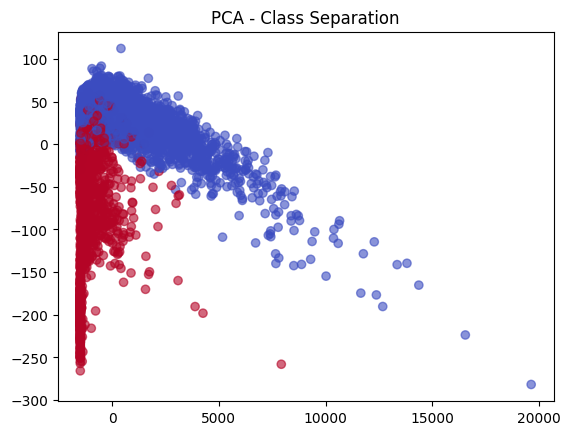

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', alpha=0.6)
plt.title("PCA - Class Separation")
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb, X, y, cv=5)
print(scores, scores.mean())


[1.         1.         1.         0.99893162 1.        ] 0.9997863247863247


# 아래 변수 제거 후 학습진행 

- date_unregistration    0.784602
- num_assessments        0.653035
- avg_score              0.526817
- unique_materials       0.407662

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# ---------------------------
# 1. 데이터 로드
# ---------------------------
df = df_2013B_clean

# ---------------------------
# 2. 타겟 생성 (Withdrawn → 1, 나머지 → 0)
# ---------------------------
df["target"] = (df["final_result"] == "Withdrawn").astype(int)
df = df.drop(columns=["final_result"], errors="ignore")

# ---------------------------
# 3. 라벨 인코딩 (문자형 → 숫자형)
# ---------------------------
for col in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# ---------------------------
# 4. 누설 변수 제거
# ---------------------------
remove_cols = ["date_unregistration", "num_assessments", "avg_score", "unique_materials"]
X = df.drop(columns=["target"] + remove_cols, errors="ignore")
y = df["target"]

# ---------------------------
# 5. 학습/테스트 분할
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------------------
# 6. 스케일링
# ---------------------------
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# ---------------------------
# 7. SMOTE로 클래스 균형 조정
# ---------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sc, y_train)

# ---------------------------
# 8. XGBoost 모델 학습
# ---------------------------
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train_res, y_train_res)

# ---------------------------
# 9. 예측 및 평가
# ---------------------------
y_train_pred = xgb.predict(X_train_sc)
y_test_pred = xgb.predict(X_test_sc)

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy : {accuracy_score(y_test, y_test_pred):.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

# ---------------------------
# 10. 과적합 여부 판단
# ---------------------------
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
gap = train_acc - test_acc

if gap > 0.1:
    print(f"⚠️ 과적합 가능성 높음 (Train-Test Gap: {gap:.4f})")
elif gap < -0.05:
    print(f"⚠️ 과소적합 가능성 (Train-Test Gap: {gap:.4f})")
else:
    print(f"✅ 과적합/과소적합 위험 낮음 (Train-Test Gap: {gap:.4f})")


Train Accuracy: 0.9044
Test Accuracy : 0.7543

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       667
           1       0.57      0.56      0.57       269

    accuracy                           0.75       936
   macro avg       0.70      0.70      0.70       936
weighted avg       0.75      0.75      0.75       936

⚠️ 과적합 가능성 높음 (Train-Test Gap: 0.1501)



=== [누설 포함 버전] PCA / 타겟 상관계수 / CV ===


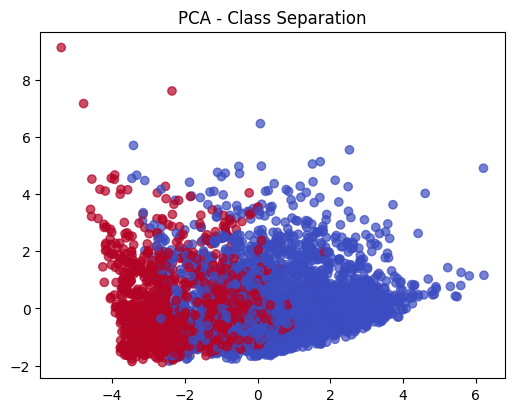

target                  1.000000
studied_credits         0.102320
disability              0.071367
highest_education       0.065345
num_of_prev_attempts    0.031675
id_student              0.002786
region                  0.001283
age_band                0.000972
date_registration      -0.018551
gender                 -0.035112
imd_band               -0.071437
total_clicks           -0.347441
unique_materials       -0.407662
avg_score              -0.526817
num_assessments        -0.653035
date_unregistration    -0.784602
dtype: float64
[1.         1.         1.         0.99893162 1.        ] 0.9997863247863247

=== [누설 제거 버전] PCA / 타겟 상관계수 / CV ===


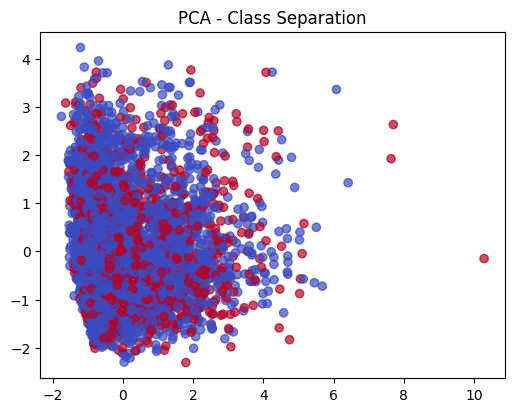

target                  1.000000
studied_credits         0.102320
disability              0.071367
highest_education       0.065345
num_of_prev_attempts    0.031675
id_student              0.002786
region                  0.001283
age_band                0.000972
date_registration      -0.018551
gender                 -0.035112
imd_band               -0.071437
dtype: float64
[0.52457265 0.51495726 0.61324786 0.59935897 0.64385027] 0.5791974039032862


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# =========================================
# 설정
# =========================================
# df를 이미 메모리에 가지고 있으면 그대로 사용 (예: df = df_2013B_clean)
# 없으면 아래 주석을 풀고 파일에서 읽으세요.
# df = pd.read_csv("../data/2013B.csv")

TARGET_NAME = "target"

# 누설(또는 예측 시점에 알 수 없는) 변수들
LEAK_COLS = [
    "date_unregistration", "num_assessments", "avg_score", "unique_materials",
    "total_clicks"   # 필요시 유지/제거를 스위치로 바꿔보세요
]

# 모델링에서 제외할 식별자
ID_COLS = ["id_student"]


def prepare_df(raw_df, drop_leaks: bool):
    df = raw_df.copy()

    # 1) 타겟 생성: Withdrawn → 1, 그 외 → 0
    if "final_result" in df.columns:
        df[TARGET_NAME] = (df["final_result"] == "Withdrawn").astype(int)
        df = df.drop(columns=["final_result"], errors="ignore")
    else:
        assert TARGET_NAME in df.columns, "final_result가 없으면 target 컬럼이 있어야 합니다."

    # 2) 라벨 인코딩 (object → int)
    for col in df.select_dtypes(include=["object"]).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

    # 3) 누설 컬럼 제거 (옵션)
    if drop_leaks:
        df = df.drop(columns=LEAK_COLS, errors="ignore")

    return df


def show_pca_corr_cv(df):
    # X, y 분리
    X = df.drop(columns=[TARGET_NAME], errors="ignore")
    y = df[TARGET_NAME].astype(int)

    # ===== PCA (시각화용: 스케일링 후 2D) =====
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(6,4.5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="coolwarm", alpha=0.7)
    plt.title("PCA - Class Separation")
    plt.show()

    # ===== 타겟과 피처 상관계수 =====
    corr_with_target = pd.Series(dtype=float)
    for col in X.columns:
        # 피어슨 상관 (둘 다 숫자이므로 직접 계산)
        corr_with_target[col] = np.corrcoef(df[col], y)[0, 1]
    corr_with_target["target"] = 1.0
    # target을 맨 위로 두고 나머지 정렬(내림차순)
    corr_sorted = corr_with_target.sort_values(ascending=False)
    print(corr_sorted)

    # ===== XGBoost + SMOTE 파이프라인 교차검증 =====
    # (주의) 모델링에서 식별자는 제외하는 것이 일반적이므로 파이프라인 전용 X 구성
    X_model = X.drop(columns=ID_COLS, errors="ignore")

    pipeline = ImbPipeline(steps=[
        ("smote", SMOTE(random_state=42)),
        ("scaler", StandardScaler()),
        ("xgb", XGBClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1
        ))
    ])

    scores = cross_val_score(pipeline, X_model, y, cv=5, scoring="accuracy")
    print(scores, scores.mean())


# =========================================
# 사용 예시
# =========================================
# 1) 누설 변수 포함 버전 (네가 보여준 결과 스타일)
df_leak = prepare_df(df_2013B_clean, drop_leaks=False)
print("\n=== [누설 포함 버전] PCA / 타겟 상관계수 / CV ===")
show_pca_corr_cv(df_leak)

# 2) 누설 변수 제거 버전 (현실적인 평가)
df_no_leak = prepare_df(df_2013B_clean, drop_leaks=True)
print("\n=== [누설 제거 버전] PCA / 타겟 상관계수 / CV ===")
show_pca_corr_cv(df_no_leak)
